*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Clustering using the Lava QUBO solver
This notebook demonstrates the usage of a Lava-Optimization QUBO solver to cluster a set of points in 2-dimensional space into clusters with *pre-specified* cluster centers.

We use a problem generator utility, which uniformly samples cluster centers and around them generates Gaussian-distributed points. Such artificially generated problem is then consumed by the clustering solver and a clustering solution is returned.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lava.lib.optimization.utils.generators.clustering_tsp_vrp import (
    GaussianSampledClusteringProblem)  # Problem generation utility
from lava.lib.optimization.apps.clustering.problems import ClusteringProblem
from lava.lib.optimization.apps.clustering.solver import (ClusteringConfig,
                                                          ClusteringSolver)

### Generate random problem

In [2]:
np.random.seed(2)
# Generate an artificial problem
domain = [(0, 0), (50, 50)]
gcp = GaussianSampledClusteringProblem(num_clusters=5,
                                       num_points=50,
                                       domain=domain,
                                       variance=2.5)

# Convert the generated coordinates to lists of tuples
ct_c = [tuple(coord) for coord in gcp.center_coords]
pt_c = [tuple(coord) for coord in gcp.point_coords]

# Generate a clustering problem that compatible for solver consumption
cp = ClusteringProblem(point_coords=pt_c,
                       center_coords=ct_c)

### Visualise the problem

Cluter center coordinates: 
[[40 15]
 [45  8]
 [22 43]
 [18 11]
 [40  7]]


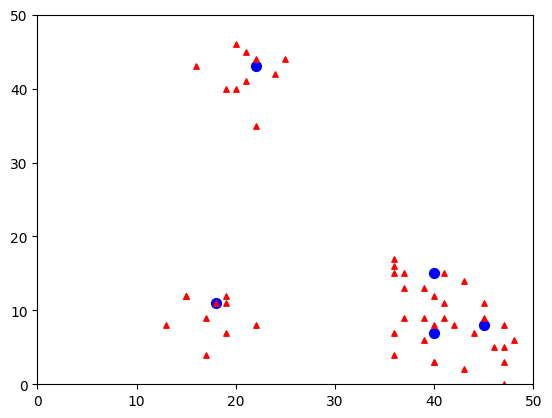

In [3]:
print(f"Cluter center coordinates: \n{gcp.center_coords}")
plt.scatter(gcp.center_coords[:, 0], gcp.center_coords[:, 1], s=50, c='b', marker='o')
plt.scatter(gcp.point_coords[:, 0], gcp.point_coords[:, 1], s=15, c='r', marker='^')
plt.xlim([domain[0][0], domain[1][1]])
plt.ylim([domain[0][0], domain[1][1]])
plt.show()

### Solve

In [4]:
solver = ClusteringSolver(clp=cp)
scfg = ClusteringConfig(backend="Loihi2",
                        hyperparameters={},
                        target_cost=-1000000,
                        timeout=1000,
                        probe_time=False,
                        log_level=20) # Change log level to 40 for suppressing the verbose output below
solver.solve(scfg=scfg)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.54.73.26:40445
INFO:DRV:      Host server up..............Done 0.37s
INFO:DRV:      Mapping chipIds.............Done 0.08ms
INFO:DRV:      Mapping coreIds.............Done 0.26ms
INFO:DRV:      Partitioning neuron groups..Done 3.70ms
INFO:DRV:      Mapping axons...............Done 0.01s
INFO:DRV:      Configuring Spike Block.....Done 0.01ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.03ms
INFO:DRV:      Initializes Python MQ.......Done 0.01ms
INFO:DRV:      Partitioning MPDS...........Done 1.00ms
INFO:DRV:      Creating Embedded Snips and ChannelsDone 9.16ms
INFO:DRV:      Compiling Embedded snips....Done 0.79s
INFO:DRV:      Compiling Host snips........Done 0.18ms
INFO:DRV:      Compiling Register Probes...Done 0.33ms
INFO:DRV:      Compiling Spike Probes......Done 0.04ms
INFO:HST:  Args chip=0 cpu=0 /home/sumedhrr/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_execution/../../../../temp/4705e2c0-6948-11ee-bb0

#### Maps between cluster centers and points
`clustering_id_map`: Center IDs -> Point IDs

`clustering_coords_map`: Center coords -> Point coords

In [5]:
print(f"Clustering ID map:\n{solver.solution.clustering_id_map}")
print(f"Clustering coords map:\n{solver.solution.clustering_coords_map}")

Clustering ID map:
{4: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45], 2: [16, 18, 19, 20, 22, 23, 25, 50, 51, 53], 3: [26, 27, 28, 29, 30, 31, 33, 34, 35], 1: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 5: [17, 21, 24, 46, 47, 48, 49, 52, 54, 55]}
Clustering coords map:
{(18, 11): [(19, 7), (17, 4), (13, 8), (19, 11), (17, 9), (15, 12), (22, 8), (15, 12), (18, 11), (19, 12)], (45, 8): [(44, 7), (46, 5), (47, 0), (48, 6), (47, 8), (47, 3), (45, 11), (45, 9), (41, 9), (47, 5)], (22, 43): [(22, 44), (21, 41), (21, 45), (25, 44), (20, 40), (16, 43), (19, 40), (24, 42), (20, 46)], (40, 15): [(37, 13), (36, 17), (41, 11), (37, 15), (36, 15), (41, 15), (43, 14), (40, 12), (39, 13), (36, 16)], (40, 7): [(43, 2), (42, 8), (40, 3), (36, 7), (40, 8), (36, 4), (39, 9), (40, 3), (37, 9), (39, 6)]}


In [6]:
clustered_coords = list(solver.solution.clustering_coords_map.values())
clustered_coords = [np.array(coords) for coords in clustered_coords]

### Visualise the clustering solution
- Black circles are cluster centers.
- Red triangles are points which did not get a cluster assignment
- Other colours represent separate clusters

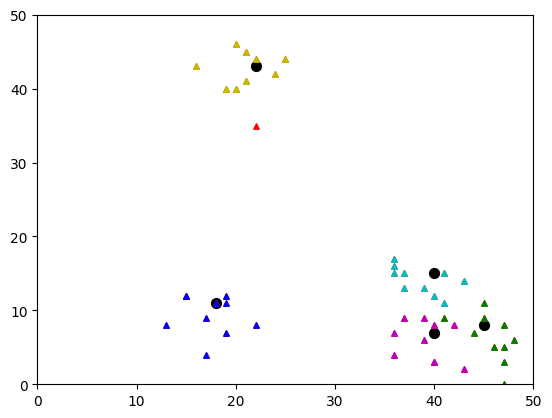

In [7]:
plt.scatter(gcp.center_coords[:, 0], gcp.center_coords[:, 1], s=50, c='k', marker='o')
plt.scatter(gcp.point_coords[:, 0], gcp.point_coords[:, 1], s=15, c='r', marker='^')
colours = ['b', 'g', 'y', 'c', 'm']
for j, cluster in enumerate(clustered_coords):
    plt.scatter(cluster[:, 0], cluster[:, 1], s=15, c=colours[j], marker='^')
plt.xlim([domain[0][0], domain[1][1]])
plt.ylim([domain[0][0], domain[1][1]])
plt.show()